<a href="https://colab.research.google.com/github/paulw-edu/ML_CV_bark_classification/blob/main/Bark_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Google Drive and download all the images

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Download the training data because having it local is way faster
!rsync -r --progress /content/drive/MyDrive/Bark_scaled/internet_v2_zip/ /content/internet_v2_zip

!mkdir /content/internet_v2/
!unzip /content/internet_v2_zip/ash.zip    -d /content/internet_v2/ash
!unzip /content/internet_v2_zip/beech.zip  -d /content/internet_v2/beech
!unzip /content/internet_v2_zip/birch.zip  -d /content/internet_v2/birch
!unzip /content/internet_v2_zip/fir.zip    -d /content/internet_v2/fir
!unzip /content/internet_v2_zip/larch.zip  -d /content/internet_v2/larch
!unzip /content/internet_v2_zip/oak.zip    -d /content/internet_v2/oak
!unzip /content/internet_v2_zip/pine.zip   -d /content/internet_v2/pine
!unzip /content/internet_v2_zip/spruce.zip -d /content/internet_v2/spruce

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: /content/internet_v2/pine/Pinus koraiensis_b794ef02.JPEG  
  inflating: /content/internet_v2/pine/PIR_4075f8d5.jpg  
  inflating: /content/internet_v2/pine/PIR_2a813965.jpg  
  inflating: /content/internet_v2/pine/PIB_0526a328.jpg  
  inflating: /content/internet_v2/pine/Pinus б┐ rigitaeda_3651206e.JPEG  
  inflating: /content/internet_v2/pine/Pinus densiflora_7cb9a82a.JPEG  
  inflating: /content/internet_v2/pine/Pinus densiflora_19e60bf4.JPEG  
  inflating: /content/internet_v2/pine/Pinus б┐ rigitaeda_c22e2b8a.JPEG  
  inflating: /content/internet_v2/pine/PIB_424fcd2f.jpg  
  inflating: /content/internet_v2/pine/PIR_8567b560.jpg  
  inflating: /content/internet_v2/pine/Pinus б┐ rigitaeda_d63fb6bb.JPEG  
  inflating: /content/internet_v2/pine/Pinus rigida_cf4b4430.JPEG  
  inflating: /content/internet_v2/pine/Pinus densiflora_e7d52436.JPG  
  inflating: /content/internet_v2/pine/PIB_2bf5ce50.jpg  
  inflat

Create a Dataset from all the Images

In [1]:
import tensorflow as tf

image_size = (512,512)

# Generate a training Dataset from the Internet Images
train_ds = tf.keras.utils.image_dataset_from_directory(
  "/content/internet_v2/",
  image_size=image_size,
  crop_to_aspect_ratio=True,
  batch_size=64,
  seed = 123,
  validation_split=0.015,
  subset='training')
dev_ds1 = tf.keras.utils.image_dataset_from_directory(
  "/content/internet_v2/",
  image_size=image_size,
  crop_to_aspect_ratio=True,
  batch_size=64,
  seed = 123,
  validation_split=0.015,
  subset='validation')


# Generate a dev set from the self labeled images
dev_ds2 = tf.keras.utils.image_dataset_from_directory(
  "/content/drive/MyDrive/Bark_scaled/self_labeled/",
  image_size=image_size,
  crop_to_aspect_ratio=True,
  batch_size=64)

class_names = train_ds.class_names
num_classes = len(class_names)

Found 21491 files belonging to 8 classes.
Using 21169 files for training.
Found 21491 files belonging to 8 classes.
Using 322 files for validation.
Found 333 files belonging to 8 classes.


Create Weights for all the classes (for the training Dataset), 
so that biases in the training data won't affect the Model too much


In [9]:
import os

baseDir = "/content/internet_v2/"
fileCount = {}
accumulate = 0.0
for i in range(len(class_names)):
    files = os.listdir(baseDir+class_names[i])
    Nrfiles = len(files)
    fileCount[i] = Nrfiles
    accumulate += Nrfiles
    print(f"{i} - {class_names[i]}: {Nrfiles}")
print(f"total: {accumulate}")
class_weight = {k: accumulate/v for k, v in fileCount.items()}
print(f"class Weight: {class_weight}")

0 - ash: 1619
1 - beech: 1521
2 - birch: 2660
3 - fir: 2101
4 - larch: 2074
5 - oak: 3957
6 - pine: 3801
7 - spruce: 3758
total: 21491.0
class Weight: {0: 13.274243360098826, 1: 14.129520052596975, 2: 8.079323308270677, 3: 10.22893860066635, 4: 10.362102217936355, 5: 5.431134698003538, 6: 5.654038410944488, 7: 5.718733368813199}


Import pre trained models and create models adjustet to our problem

In [21]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

# clear the old session
keras.backend.clear_session() 

# create the base pre-trained model
input_tensor = layers.Input(shape=(image_size[0], image_size[1], 3))
i = layers.Rescaling(1.0 / 255)(input_tensor) # do rescaling
base_model_InceptionV3 = InceptionV3(input_tensor=i, weights='imagenet', include_top=False)
base_model_MobileNetV2 = MobileNetV2(input_tensor=i, weights='imagenet', include_top=False)
base_model_VGG16 = VGG16(input_tensor=i, weights='imagenet', include_top=False)
base_model_VGG19 = VGG19(input_tensor=i, weights='imagenet', include_top=False)

def createModel(base_model):
  # add a global spatial average pooling layer
  x = base_model.output
  x = layers.GlobalAveragePooling2D()(x)
  # let's add a fully-connected layer
  x = layers.Flatten()(x)
  x = layers.Dense(1024, activation='relu')(x)
  # and a logistic layer -- let's say we have 200 classes
  predictions = layers.Dense(num_classes, activation='softmax')(x)

  # this is the model we will train
  model = keras.models.Model(inputs=base_model.input, outputs=predictions)

  # first: train only the top layers (which were randomly initialized)
  # i.e. freeze all convolutional InceptionV3 layers
  for layer in base_model.layers:
      layer.trainable = False

  # compile the model (should be done *after* setting layers to non-trainable)
  # use sparce categorical crossentropy because labels are integer encoded in the dataset
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                loss=keras.losses.sparse_categorical_crossentropy,
                metrics=['accuracy'])

  return model

# our final models:
model_InceptionV3 = createModel(base_model_InceptionV3)
model_MobileNetV2 = createModel(base_model_MobileNetV2)
model_VGG16 = createModel(base_model_VGG16)
model_VGG19 = createModel(base_model_VGG19)

We can have a look at our models using keras plot_model function
Show the InceptionV3 Model

In [ ]:
# Show how the model is build
keras.utils.plot_model(model_InceptionV3, show_shapes=True)

Show the MobileNetV2 Model

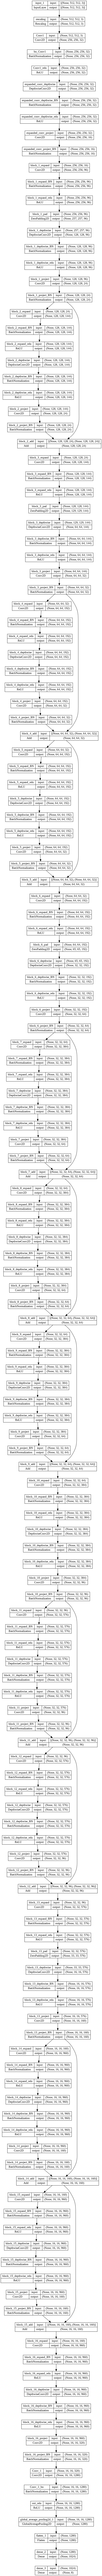

In [ ]:
keras.utils.plot_model(model_MobileNetV2, show_shapes=True)

Show the VGG16 Model

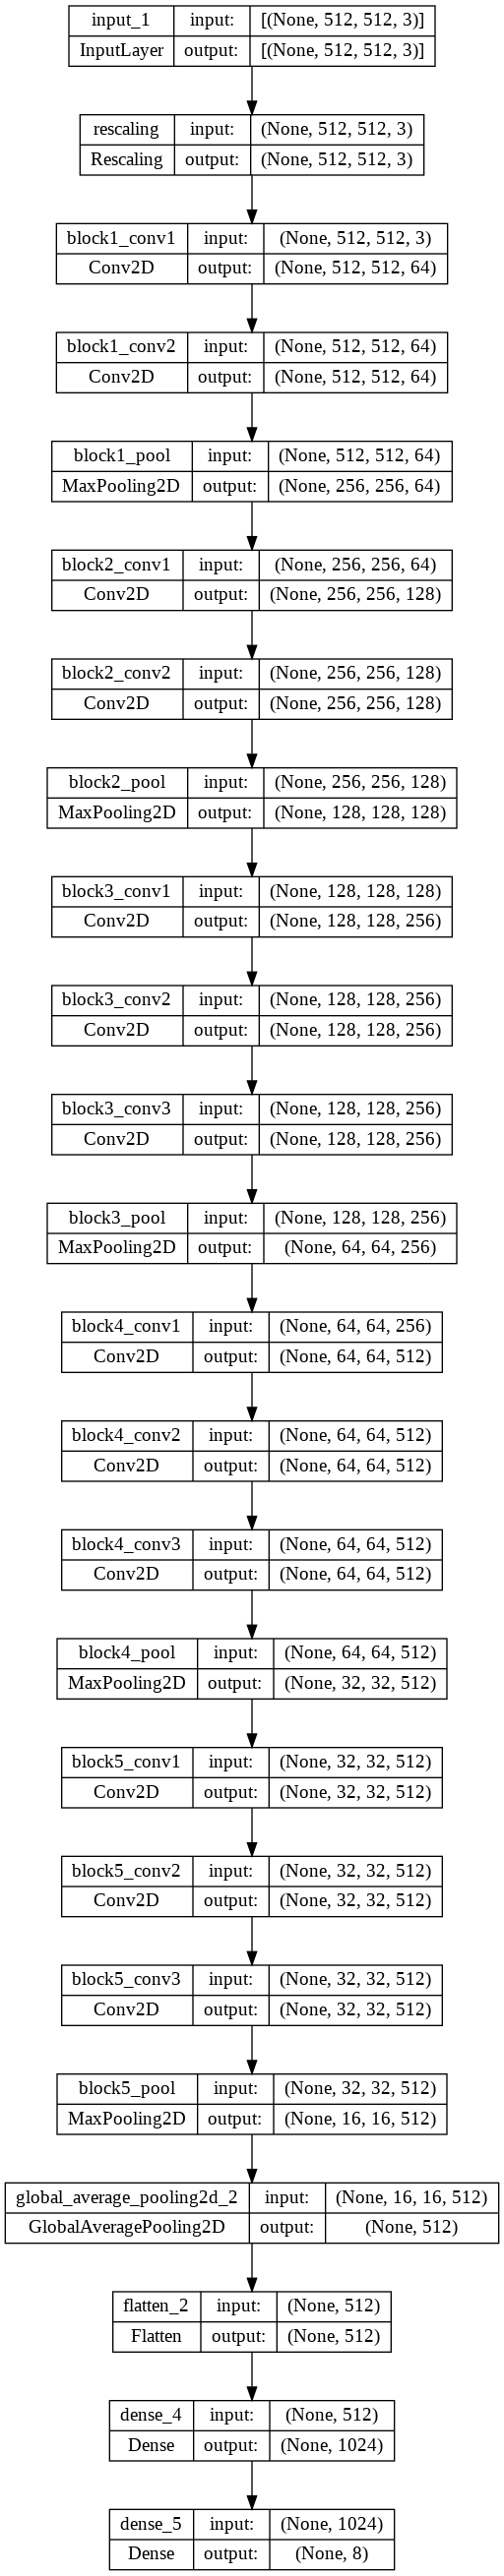

In [ ]:
keras.utils.plot_model(model_VGG16, show_shapes=True)

Show the VGG19 Model

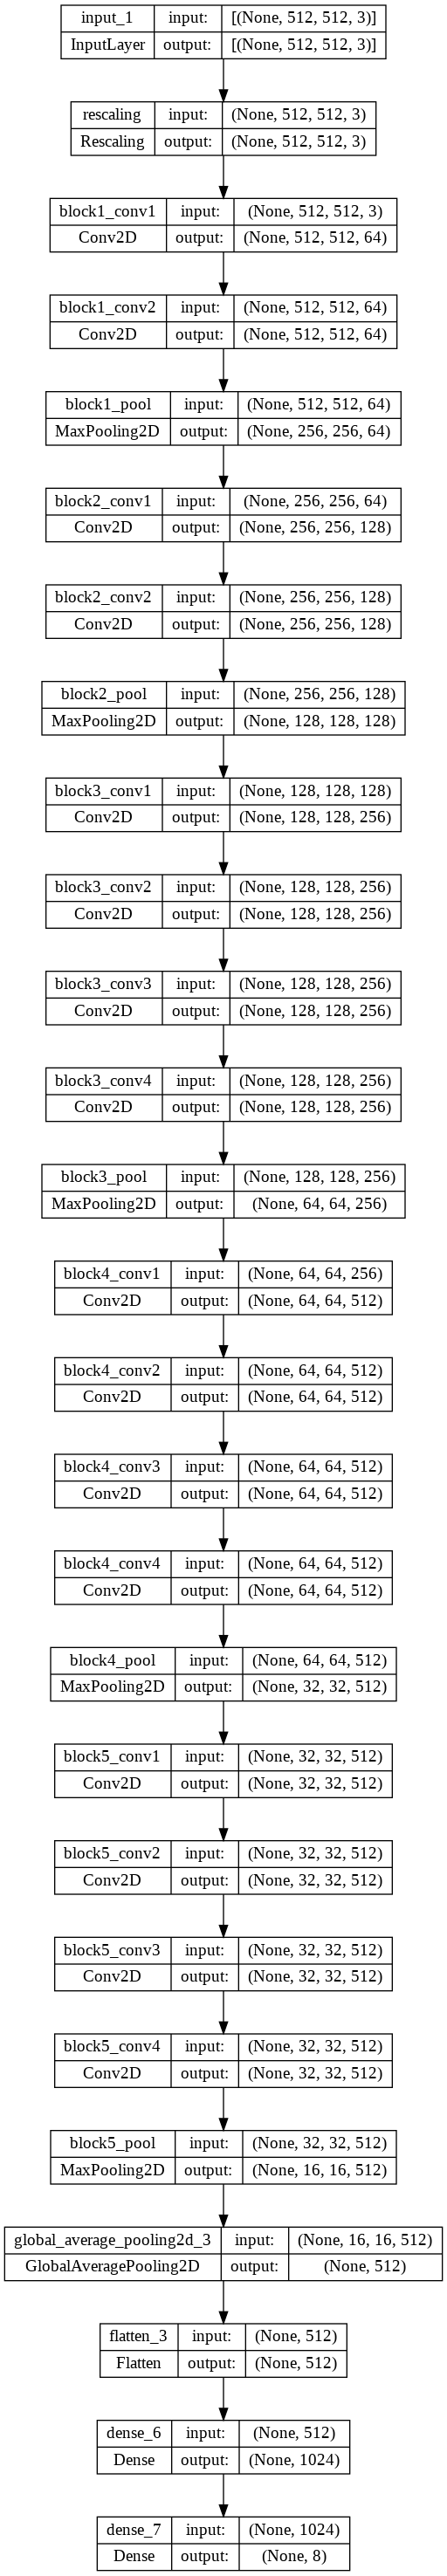

In [ ]:
keras.utils.plot_model(model_VGG19, show_shapes=True)

Function to plot the training history

In [48]:
import matplotlib.pyplot as plt

def show_history(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'dev'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'dev'], loc='upper left')
    plt.show() 

Function to train a model on our training data

the number of epochs and the steps per epoch should be adjusted on the fly, depending on the goal of training. (if it is just for testing or the final training etc.)

In [19]:
def train(model, epochs=2, steps=10):
  # train the model on the new data for a few epochs
  print("training...")
  history = model.fit(
      x=train_ds, 
      validation_data=dev_ds1, 
      class_weight=class_weight, 
      steps_per_epoch=steps,
      validation_steps=5,
      verbose=1, 
      epochs=epochs
      )
  return history

Train our model based on InceptionV3 and plot the history

training...
Epoch 1/16
20/20 [==============================] - 41s 1s/step - loss: 11.2916 - accuracy: 0.5141 - val_loss: 0.8720 - val_accuracy: 0.6812
Epoch 2/16
20/20 [==============================] - 21s 1s/step - loss: 6.5357 - accuracy: 0.7055 - val_loss: 0.7521 - val_accuracy: 0.7344
Epoch 3/16
20/20 [==============================] - 21s 1s/step - loss: 5.4866 - accuracy: 0.7484 - val_loss: 0.7265 - val_accuracy: 0.7563
Epoch 4/16
20/20 [==============================] - 21s 1s/step - loss: 4.6898 - accuracy: 0.7945 - val_loss: 0.6771 - val_accuracy: 0.7906
Epoch 5/16
20/20 [==============================] - 20s 1s/step - loss: 4.6634 - accuracy: 0.8055 - val_loss: 0.6891 - val_accuracy: 0.7656
Epoch 6/16
20/20 [==============================] - 21s 1s/step - loss: 4.4383 - accuracy: 0.8102 - val_loss: 0.5465 - val_accuracy: 0.8188
Epoch 7/16
20/20 [==============================] - 21s 1s/step - loss: 4.2019 - accuracy: 0.8164 - val_loss: 0.6211 - val_accuracy: 0.8094
Epoch 8

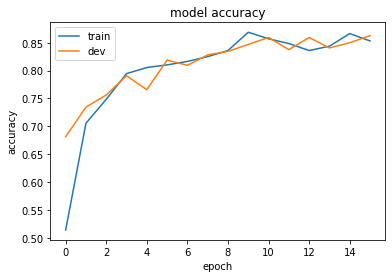

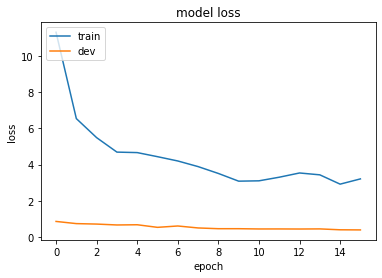

In [ ]:
show_history(train(model_InceptionV3, 16, 20))

Train our model based on MobileNetV2 and plot the history

training...
Epoch 1/16
20/20 [==============================] - 17s 631ms/step - loss: 12.6450 - accuracy: 0.4570 - val_loss: 1.1338 - val_accuracy: 0.6469
Epoch 2/16
20/20 [==============================] - 12s 600ms/step - loss: 7.9117 - accuracy: 0.7070 - val_loss: 0.8716 - val_accuracy: 0.7188
Epoch 3/16
20/20 [==============================] - 12s 597ms/step - loss: 6.6095 - accuracy: 0.7258 - val_loss: 0.7560 - val_accuracy: 0.7625
Epoch 4/16
20/20 [==============================] - 12s 597ms/step - loss: 5.5809 - accuracy: 0.7953 - val_loss: 0.6933 - val_accuracy: 0.7812
Epoch 5/16
20/20 [==============================] - 12s 598ms/step - loss: 5.4585 - accuracy: 0.7891 - val_loss: 0.6211 - val_accuracy: 0.7906
Epoch 6/16
20/20 [==============================] - 12s 587ms/step - loss: 4.8471 - accuracy: 0.8102 - val_loss: 0.6261 - val_accuracy: 0.8094
Epoch 7/16
20/20 [==============================] - 12s 594ms/step - loss: 4.5373 - accuracy: 0.8133 - val_loss: 0.5831 - val_acc

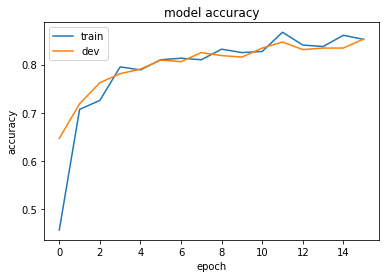

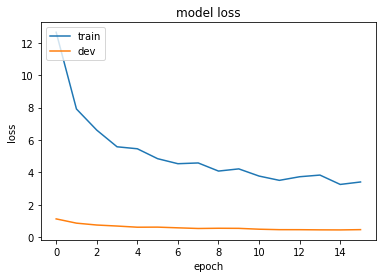

In [22]:
show_history(train(model_MobileNetV2, 16, 20))

Train our model based on VGG16 and plot the history

training...
Epoch 1/16
20/20 [==============================] - 87s 2s/step - loss: 13.9922 - accuracy: 0.3633 - val_loss: 1.4900 - val_accuracy: 0.5094
Epoch 2/16
20/20 [==============================] - 48s 2s/step - loss: 10.4457 - accuracy: 0.5672 - val_loss: 1.2015 - val_accuracy: 0.6531
Epoch 3/16
20/20 [==============================] - 48s 2s/step - loss: 9.1364 - accuracy: 0.6141 - val_loss: 1.0858 - val_accuracy: 0.6625
Epoch 4/16
20/20 [==============================] - 48s 2s/step - loss: 7.8345 - accuracy: 0.6844 - val_loss: 1.0309 - val_accuracy: 0.6594
Epoch 5/16
20/20 [==============================] - 48s 2s/step - loss: 7.7024 - accuracy: 0.6508 - val_loss: 0.9456 - val_accuracy: 0.6687
Epoch 6/16
20/20 [==============================] - 48s 2s/step - loss: 7.0562 - accuracy: 0.6945 - val_loss: 0.9313 - val_accuracy: 0.6781
Epoch 7/16
20/20 [==============================] - 48s 2s/step - loss: 6.8732 - accuracy: 0.6969 - val_loss: 0.8947 - val_accuracy: 0.7031
Epoch 

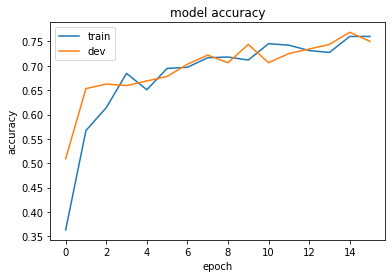

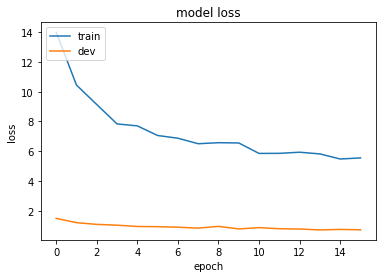

In [ ]:
show_history(train(model_VGG16, 16, 20))

Train our model based on VGG19 and plot the history

training...
Epoch 1/16
20/20 [==============================] - 60s 3s/step - loss: 14.9899 - accuracy: 0.2758 - val_loss: 1.6429 - val_accuracy: 0.3969
Epoch 2/16
20/20 [==============================] - 57s 3s/step - loss: 12.1416 - accuracy: 0.4625 - val_loss: 1.4975 - val_accuracy: 0.5219
Epoch 3/16
20/20 [==============================] - 57s 3s/step - loss: 10.3428 - accuracy: 0.5562 - val_loss: 1.2375 - val_accuracy: 0.6000
Epoch 4/16
20/20 [==============================] - 57s 3s/step - loss: 9.5466 - accuracy: 0.5734 - val_loss: 1.2096 - val_accuracy: 0.5719
Epoch 5/16
20/20 [==============================] - 57s 3s/step - loss: 9.2146 - accuracy: 0.5914 - val_loss: 1.0971 - val_accuracy: 0.6500
Epoch 6/16
20/20 [==============================] - 57s 3s/step - loss: 8.3523 - accuracy: 0.6414 - val_loss: 0.9957 - val_accuracy: 0.6781
Epoch 7/16
20/20 [==============================] - 57s 3s/step - loss: 7.7876 - accuracy: 0.6641 - val_loss: 1.0143 - val_accuracy: 0.6531
Epoch

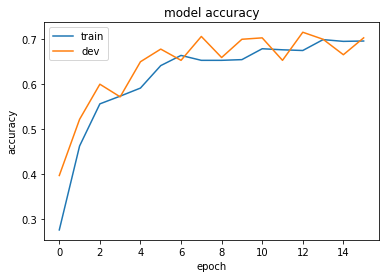

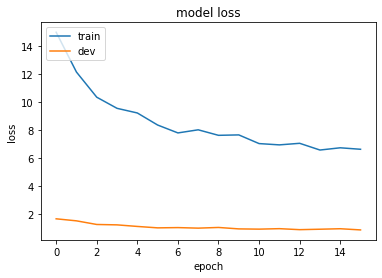

In [ ]:
show_history(train(model_VGG19, 16, 20))

Try out the models (on the dev set) and compare their performance

In [ ]:
print("InceptionV3")
predictions = model_InceptionV3.predict(dev_ds2)
model_InceptionV3.evaluate(dev_ds2)
model_InceptionV3.evaluate(dev_ds1)

print("MobileNetV2")
model_MobileNetV2.evaluate(dev_ds2)
model_MobileNetV2.evaluate(dev_ds1)

print("VGG16")
model_VGG16.evaluate(dev_ds2)
model_VGG16.evaluate(dev_ds1)

print("VGG19")
model_VGG19.evaluate(dev_ds2)
model_VGG19.evaluate(dev_ds1)

InceptionV3
6/6 [==============================] - 6s 953ms/step - loss: 0.4042 - accuracy: 0.8634
MobileNetV2
6/6 [==============================] - 3s 433ms/step - loss: 0.2820 - accuracy: 0.8882
VGG16
6/6 [==============================] - 12s 2s/step - loss: 0.7205 - accuracy: 0.7516
VGG19
6/6 [==============================] - 12s 2s/step - loss: 0.8443 - accuracy: 0.7050


[0.8442575931549072, 0.7049689292907715]

Plot the Models guesses depending on class.
so how often the Model predicts a specific class if the input image is from another or the same class

on the left is the true class and then the prediction percentage of the Model.

absolute=True uses the Max value of the Models prediction probabilities only and
absolute=False uses all the probabilities of the Model predictions to generate the table

This shows which categories are Similar to other categories.
Meaning the categories where the Model guesses wrong often either have a discrepancy between training and dev data or are simmilar to another category.

This could be because the Datasets are an accumulation of different tree species in the same supercategory while the Data from the Dev set is mainly from one exact species in that supercategory.

In [ ]:
import numpy as np

def plot_model_predictions(class_names, predictions, dev_ds, absolute=True):
    index = 0
    acc = np.zeros((len(class_names),len(class_names)))
    for (x,y) in dev_ds:
        valY = tf.keras.backend.get_value(y)
        valX = tf.keras.backend.get_value(y)
        for i in range(len(valY)):
            y = valY[i]
            pred = predictions[index]
            if absolute:
              acc[y,pred.argmax()]+=1
            else:
              acc[y,:] += pred
            index +=1


    print('class  ', end='')
    for c in class_names:
        print(f'{c:<7}', end='')
    print('')
    for i in range(len(acc)):
        print(f'{class_names[i]:<7}', end='')
        for j in range(len(class_names)):
            all_guesses = sum(acc[i])
            print(f'{acc[i][j]/all_guesses:<7,.2f}', end='')
        print('')
  
plot_model_predictions(class_names, predictions, dev_ds2, True)

class  ash    beech  birch  fir    larch  oak    pine   spruce 
ash    0.00   0.14   0.00   0.00   0.00   0.43   0.29   0.14   
beech  0.00   0.12   0.00   0.05   0.04   0.25   0.37   0.18   
birch  0.04   0.12   0.00   0.00   0.00   0.33   0.38   0.12   
fir    0.00   0.18   0.05   0.00   0.14   0.18   0.32   0.14   
larch  0.02   0.26   0.00   0.03   0.10   0.23   0.21   0.16   
oak    0.00   0.12   0.00   0.05   0.02   0.19   0.42   0.21   
pine   0.02   0.11   0.00   0.04   0.04   0.20   0.38   0.20   
spruce 0.03   0.19   0.00   0.05   0.04   0.23   0.36   0.10   


# Fine Tuning

Improving the Model by learning the lower half

First we save the model, so it can be restored easily after finetuning

In [11]:
model_MobileNetV2.save("/content/MobileNetV2_pre_finetune")

In [49]:
# clear the old session
tf.keras.backend.clear_session() 

MobileNetV2_finetuning = tf.keras.models.load_model("/content/MobileNetV2_pre_finetune")
#MobileNetV2_finetuning.evaluate(dev_ds1)

In [50]:
# now we fine tune the lower half of the MobileNet Model

layer_count = len(MobileNetV2_finetuning.layers)
train_layers = 15
for layer in MobileNetV2_finetuning.layers[:layer_count-train_layers]:
    layer.trainable = False

# print the trainable layers
for layer in MobileNetV2_finetuning.layers[layer_count-train_layers:]:
    print(layer.name)
#
## we need to recompile the model for these modifications to take effect
## we use SGD with a low learning rate
MobileNetV2_finetuning.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                               loss=tf.keras.losses.sparse_categorical_crossentropy,
                               metrics=['accuracy'])

block_16_expand
block_16_expand_BN
block_16_expand_relu
block_16_depthwise
block_16_depthwise_BN
block_16_depthwise_relu
block_16_project
block_16_project_BN
Conv_1
Conv_1_bn
out_relu
global_average_pooling2d_1
flatten_1
dense_2
dense_3


Now we can train the Model again

Epoch 17/32
20/20 [==============================] - 16s 618ms/step - loss: 1.7763 - accuracy: 0.9148 - val_loss: 0.2789 - val_accuracy: 0.8938
Epoch 18/32
20/20 [==============================] - 12s 584ms/step - loss: 1.8700 - accuracy: 0.9195 - val_loss: 0.2524 - val_accuracy: 0.8938
Epoch 19/32
20/20 [==============================] - 13s 637ms/step - loss: 1.8680 - accuracy: 0.9117 - val_loss: 0.2948 - val_accuracy: 0.8969
Epoch 20/32
20/20 [==============================] - 12s 614ms/step - loss: 1.8761 - accuracy: 0.9164 - val_loss: 0.2532 - val_accuracy: 0.9000
Epoch 21/32
20/20 [==============================] - 12s 600ms/step - loss: 1.5159 - accuracy: 0.9352 - val_loss: 0.2519 - val_accuracy: 0.9062
Epoch 22/32
20/20 [==============================] - 12s 585ms/step - loss: 1.5115 - accuracy: 0.9320 - val_loss: 0.2543 - val_accuracy: 0.9094
Epoch 23/32
20/20 [==============================] - 12s 591ms/step - loss: 1.4711 - accuracy: 0.9391 - val_loss: 0.2568 - val_accuracy:

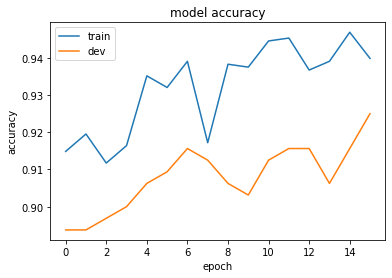

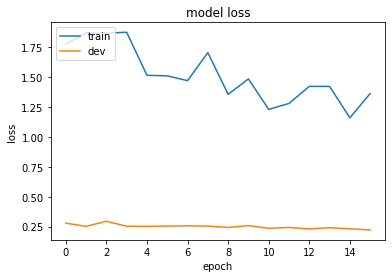

In [51]:
history = MobileNetV2_finetuning.fit(
      x=train_ds, 
      validation_data=dev_ds1, 
      class_weight=class_weight, 
      steps_per_epoch=20,
      validation_steps=5,
      verbose=1, 
      epochs=32,
      initial_epoch=16
      )
show_history(history)

Now evaluating the Model, we get:

In [52]:
print("MobileNetV2 fine tuned")
MobileNetV2_finetuning.evaluate(dev_ds2)
MobileNetV2_finetuning.evaluate(dev_ds1)

MobileNetV2 fine tuned
6/6 [==============================] - 3s 362ms/step - loss: 0.2255 - accuracy: 0.9224


[0.2254621386528015, 0.9223602414131165]